# Quantization of Signals

*This jupyter/Python notebook is part of a [collection of notebooks](../index.ipynb) in the masters module [Digital Signal Processing](http://www.int.uni-rostock.de/Digitale-Signalverarbeitung.48.0.html), Comunications Engineering, Universität Rostock. Please direct questions and suggestions to <mailto:Sascha.Spors@uni-rostock.de>.*

## Non-Linear Requantization of a Speech Signal

Speech signals have a [non-uniform amplitude distribution](../random_signals/important_distributions.ipynb#Example) which is often modeled by the Laplace distribution. Linear uniform quantization is not optimal for speech signals, since small signal amplitudes are more likely than higher ones. This motivates a non-linear quantization scheme, where the signal is companded before linear quantization and expanded afterwards. 

The following example illustrates the [A-law companding](https://en.wikipedia.org/wiki/A-law_algorithm) used in European telephone networks. The signal was originally recorded with a wordlength of $w=16$ bits using linear uniform quantization. First the A-law compansion is applied, then quantization by a linear uniform quantizer with a wordlength of $w=8$ bits. For a sampling rate of $f_s = 8$ kHz this results in a bit-rate of 64 kbits/s used in the backbone of many telephone networks.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf


def A_law_compander(x):
    A = 87.6
    y = np.zeros_like(x)
    idx = np.where(np.abs(x) < 1/A)
    y[idx] = A*np.abs(x[idx]) / (1 + np.log(A))
    idx = np.where(np.abs(x) >= 1/A)
    y[idx] = (1 + np.log(A*np.abs(x[idx]))) / (1 + np.log(A))
    
    return np.sign(x)*y

def A_law_expander(y):
    A = 87.6
    x = np.zeros_like(y)
    idx = np.where(np.abs(y) < 1/(1+np.log(A)))
    x[idx] = np.abs(y[idx])*(1+np.log(A)) / A
    idx = np.where(np.abs(y) >= 1/(1+np.log(A)))
    x[idx] = np.exp(np.abs(y[idx])*(1+np.log(A))-1)/A
    
    return np.sign(y)*x

def uniform_midtread_quantizer(x, w):
    # quantization step
    Q = 1/(2**(w-1))
    # limiter
    x = np.copy(x)
    idx = np.where(x <= -1)
    x[idx] = -1
    idx = np.where(x > 1 - Q)
    x[idx] = 1 - Q
    # linear uniform quantization
    xQ = Q * np.floor(x/Q + 1/2)
    
    return xQ

def evaluate_requantization(x, xQ):
    e = xQ - x
    # SNR
    SNR = 10*np.log10(np.var(x)/np.var(e))
    print('SNR: %f dB'%SNR)
    # normalize error
    e = .2 * e / np.max(np.abs(e))
    return e

### Quantization Characteristic

Lets first take a look at the non-linear characteristic of the A-law requantizer. The left plot shows the characteristic of the A-law companding and linear-quantization. The right plot shows the overall characteristic for companding, linear quantization and expansion. 

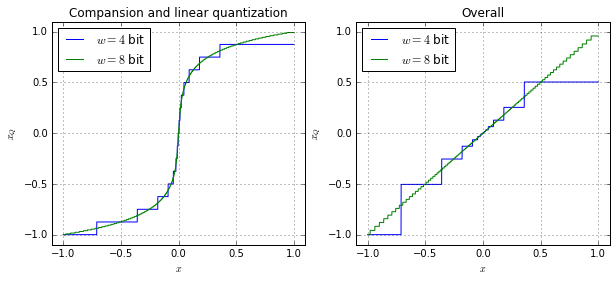

In [2]:
x = np.linspace(-1, 1, 2**16)
y = A_law_compander(x)
yQ4 = uniform_midtread_quantizer(y, 4)
yQ8 = uniform_midtread_quantizer(y, 8)
xQ4 = A_law_expander(yQ4)
xQ8 = A_law_expander(yQ8)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(x, yQ4, label=r'$w=4$ bit')
plt.plot(x, yQ8, label=r'$w=8$ bit')
plt.title('Compansion and linear quantization')
plt.xlabel(r'$x$')
plt.ylabel(r'$x_Q$')
plt.legend(loc=2)
plt.axis([-1.1, 1.1, -1.1, 1.1])
plt.grid()

plt.subplot(122)
plt.plot(x, xQ4, label=r'$w=4$ bit')
plt.plot(x, xQ8, label=r'$w=8$ bit')
plt.title('Overall')
plt.xlabel(r'$x$')
plt.ylabel(r'$x_Q$')
plt.legend(loc=2)
plt.axis([-1.1, 1.1, -1.1, 1.1])
plt.grid()

### Signal-to-Noise Ratio

Now the signal-to-noise ratio (SNR) is computed for a Laplace distributed signal for various probabilities $\Pr \{ |x[k]| > x_\text{max} \}$ that clipping occurs. The results show that the non-linear quantization scheme provides a constant SNR over a wide range of signal amplitudes. The SNR is additional higher as for [linear quantization](../quantization/linear_uniform_quantization_error.ipynb#Example) of a Laplace distributed signal. 

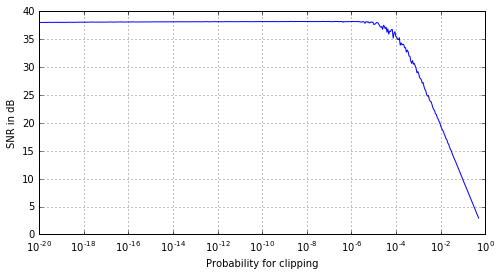

In [3]:
w = 8  # wordlength of the quantized signal
Pc = np.logspace(-20, np.log10(.5), num=500)  # probabilities for clipping
N = int(1e6)  # number of samples


def compute_SNR(Pc):
    # compute input signal
    sigma_x = - np.sqrt(2) / np.log(Pc)
    x = np.random.laplace(size=N, scale=sigma_x/np.sqrt(2) )
    # quantize signal
    y = A_law_compander(x)
    yQ = uniform_midtread_quantizer(y, 8)
    xQ = A_law_expander(yQ)
    e = xQ - x
    # compute SNR
    SNR = 10*np.log10((np.var(x)/np.var(e)))
    
    return SNR


# quantization step
Q = 1/(2**(w-1))
# compute SNR for given probabilities
SNR = [compute_SNR(P) for P in Pc]

# plot results
plt.figure(figsize=(8,4))
plt.semilogx(Pc, SNR)
plt.xlabel('Probability for clipping')
plt.ylabel('SNR in dB')
plt.grid()

### Requantization of a Speech Sample

Finally we requantize a speech sample with a linear and the A-law quantization scheme. Listen to the samples!

In [5]:
# load speech sample
x, fs = sf.read('../data/speech_8k.wav')
x = x/np.max(np.abs(x))

# linear quantization
xQ = uniform_midtread_quantizer(x, 8)
e = evaluate_requantization(x, xQ)
sf.write('speech_8k_8bit.wav', xQ, fs)
sf.write('speech_8k_8bit_error.wav', e, fs)

# A-law quantization
y = A_law_compander(x)
yQ = uniform_midtread_quantizer(y, 8)
xQ = A_law_expander(yQ)
e = evaluate_requantization(x, xQ)
sf.write('speech_Alaw_8k_8bit.wav', xQ, fs)
sf.write('speech_Alaw_8k_8bit_error.wav', e, fs)

SNR: 35.749340 dB
SNR: 38.177564 dB


**Original Signal**
<audio src="../data/speech_8k.wav" controls>Your browser does not support the audio element.</audio>
[../data/speech_8k.wav](../data/speech.wav)

**Linear Requantization to $w=8$ bit** 

Signal
<audio src="speech_8k_8bit.wav" controls>Your browser does not support the audio element.</audio>
[speech_8k_8bit.wav](speech_8k_8bit.wav)

Error
<audio src="speech_8k_8bit_error.wav" controls>Your browser does not support the audio element.</audio>
[speech_8k_8bit_error.wav](speech_8k_8bit_error.wav)

**A-law Requantization to $w=8$ bit**

Signal
<audio src="speech_Alaw_8k_8bit.wav" controls>Your browser does not support the audio element.</audio>
[speech_Alaw_8k_8bit.wav](speech_Alaw_8k_8bit.wav)

Error
<audio src="speech_Alaw_8k_8bit_error.wav" controls>Your browser does not support the audio element.</audio>
[speech_Alaw_8k_8bit_error.wav](speech_Alaw_8k_8bit_error.wav)

**Copyright**

<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>